In [14]:
from utils import *
from genetic_new import *
random.seed(42)

In [15]:
import pandas as pd
import re

def extract_data(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()

    uld_data = []
    package_data = []
    
    # Define regex patterns
    uld_pattern = re.compile(r'^U\d+,\d+,\d+,\d+,\d+')
    package_pattern = re.compile(r'^P-\d+,\d+,\d+,\d+,\d+,(Priority|Economy),[-\d]+')
    
    # Flags to determine the section
    uld_section = False
    package_section = False
    
    for line in lines:
        line = line.strip()
        
        # Detect sections
        if line.startswith("ULD attributes"):
            uld_section = True
            package_section = False
            continue
        elif line.startswith("Package attributes"):
            uld_section = False
            package_section = True
            continue
        
        # Extract ULD data
        if uld_section and uld_pattern.match(line):
            uld_id, length, width, height, weight_limit = line.split(',')
            uld_data.append({
                "ULD Identifier": uld_id,
                "Length (cm)": int(length),
                "Width (cm)": int(width),
                "Height (cm)": int(height),
                "Weight Limit (kg)": int(weight_limit)
            })
        
        # Extract package data
        if package_section and package_pattern.match(line):
            parts = line.split(',')
            package_data.append({
                "Package Identifier": parts[0],
                "Length (cm)": int(parts[1]),
                "Width (cm)": int(parts[2]),
                "Height (cm)": int(parts[3]),
                "Weight (kg)": int(parts[4]),
                "Type": parts[5],
                "Cost of Delay": parts[6] if parts[6] != '-' else None
            })
    
    return uld_data, package_data

# Usage
file_path = 'Challange_FedEx.txt'  # Replace with your text file's path
uld_data, package_data = extract_data(file_path)
pkgs_df = pd.DataFrame(package_data)
uld_df = pd.DataFrame(uld_data)
pkgs_df['Cost of Delay'] = pd.to_numeric(pkgs_df['Cost of Delay'], errors='coerce')
pkgs_df['Cost of Delay'] = pd.to_numeric(pkgs_df['Cost of Delay'], errors='coerce')
pkgs_df["Volume (cm3)"] = pkgs_df["Length (cm)"] * pkgs_df["Width (cm)"] * pkgs_df["Height (cm)"]
uld_df["Volume (cm3)"] = uld_df["Length (cm)"] * uld_df["Width (cm)"] * uld_df["Height (cm)"]

In [16]:
total_pri_vol = pkgs_df[pkgs_df["Type"] == "Priority"]["Volume (cm3)"].sum()
total_pri_weight = pkgs_df[pkgs_df["Type"] == "Priority"]["Weight (kg)"].sum()
uld_df = uld_df.sort_values(by="Volume (cm3)", ascending=False)
totvol = 0
for i in range(uld_df.shape[0]):
    totvol += uld_df.iloc[i]["Volume (cm3)"]
    if totvol >= total_pri_vol:
        break

vol_min = i+1

uld_df = uld_df.sort_values(by="Weight Limit (kg)", ascending=False)
totwt = 0
for i in range(uld_df.shape[0]):
    totwt += uld_df.iloc[i]["Weight Limit (kg)"]
    if totwt >= total_pri_weight:
        break

wt_min = i+1

min_req = max(vol_min, wt_min)

In [17]:
print(min_req)

3


In [18]:
pri_pkgs_df_vol = pkgs_df[pkgs_df["Type"] == "Priority"].sort_values(by=["Volume (cm3)", "Package Identifier"], ascending=False).reset_index(drop=True) 
uld_df = uld_df.sort_values(by=["Volume (cm3)", "ULD Identifier"], ascending=False).reset_index(drop=True)
uld_list = uld_df[['ULD Identifier','Length (cm)', 'Width (cm)', 'Height (cm)', 'Weight Limit (kg)']].values.tolist()
pri_boxes_vol = [Box(pri_pkgs_df_vol.loc[i, 'Package Identifier'], pri_pkgs_df_vol.loc[i, 'Length (cm)'], pri_pkgs_df_vol.loc[i, 'Width (cm)'], pri_pkgs_df_vol.loc[i, 'Height (cm)'], pri_pkgs_df_vol.loc[i, 'Weight (kg)'], True) for i in range(pri_pkgs_df_vol.shape[0])]
population = [[[i, randint(0, 5)] for i in range(len(pri_boxes_vol))] for _ in range(500)]
ulds = uld_list[:min_req]

In [19]:
ulds

[['U6', 244, 318, 285, 3500],
 ['U5', 244, 318, 285, 3500],
 ['U4', 244, 318, 244, 2800]]

In [14]:
new_pop, best_gene, best_fitness, fit_list =genetic_algorithm(ulds, pri_boxes_vol, 50, 100, 0.01, 0.01, initial_pop=population)

40
Generation 0: Min fitness: 3873459
Generation 1: Min fitness: 2794912
Generation 2: Min fitness: 2794912
Generation 3: Min fitness: 2648046
Generation 4: Min fitness: 2475000
Generation 5: Min fitness: 2475000
Generation 6: Min fitness: 2475000
Generation 7: Min fitness: 2352345
Generation 8: Min fitness: 2352345
Generation 9: Min fitness: 2132038
Generation 10: Min fitness: 1714294
Generation 11: Min fitness: 1714294
Generation 12: Min fitness: 1714294
Generation 13: Min fitness: 1714294
Generation 14: Min fitness: 1714294
Generation 15: Min fitness: 1714294
Generation 16: Min fitness: 1489034
Generation 17: Min fitness: 1489034
Generation 18: Min fitness: 1489034
Generation 19: Min fitness: 1489034
Generation 20: Min fitness: 1489034
Generation 21: Min fitness: 1489034
Generation 22: Min fitness: 1489034
Generation 23: Min fitness: 1421552
Generation 24: Min fitness: 1421552
Generation 25: Min fitness: 1421552
Generation 26: Min fitness: 1373708
Generation 27: Min fitness: 1373708

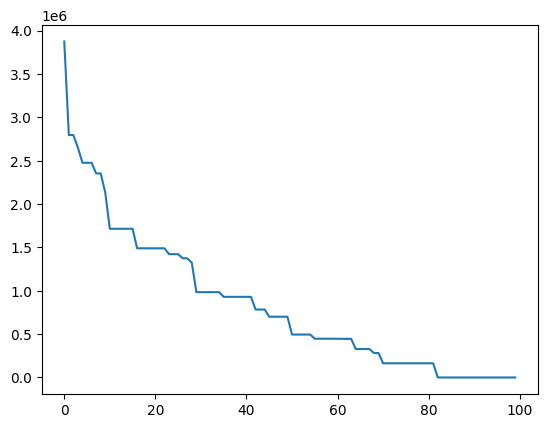

In [15]:
plt.plot(fit_list)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


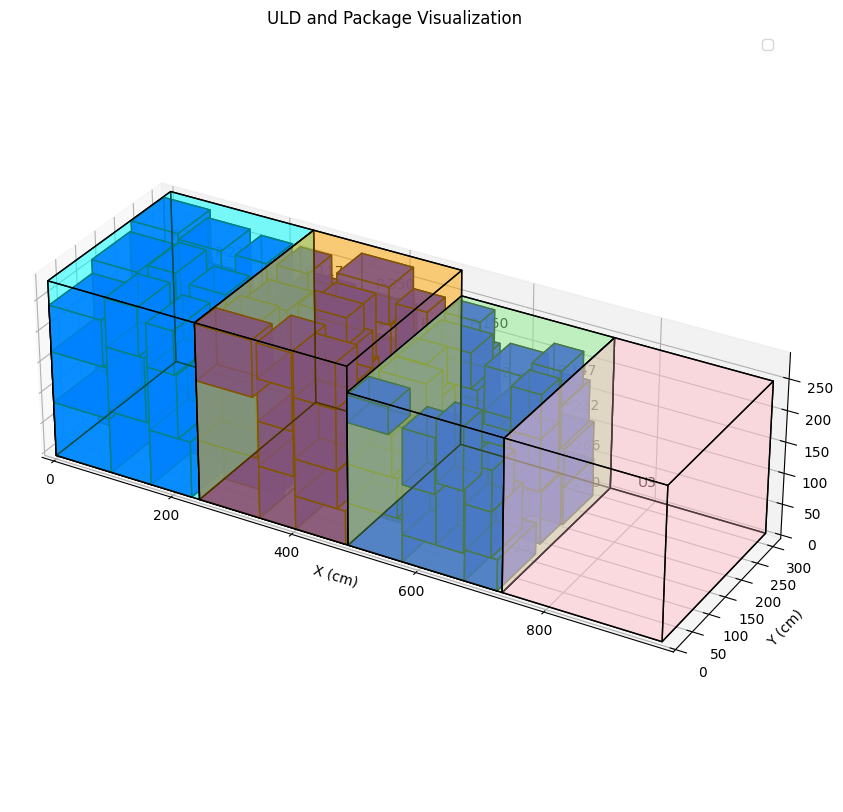

In [16]:
# placement = fitness(best_gene, pri_boxes_vol, uld_list[:min_req+1], cost_type='volume')[2]
# boxes = pri_boxes_vol
# ans = []
# for i in range(len(placement)):
#     if placement[i][1] != None:
#         l = boxes[placement[i][0]].orient(placement[i][1])[0]
#         w = boxes[placement[i][0]].orient(placement[i][1])[1]
#         h = boxes[placement[i][0]].orient(placement[i][1])[2]
#         ans.append((boxes[placement[i][0]].name, uld_list[placement[i][2][3]][0], placement[i][2][0], placement[i][2][1], placement[i][2][2], placement[i][2][0]+l, placement[i][2][1]+w, placement[i][2][2]+h))
#     else:
#         ans.append((boxes[placement[i][0]].name, 'None', None, None, None, None, None, None))

# ans_df = pd.DataFrame(ans, columns=['Package Identifier', 'ULD Identifier', 'X0', 'Y0', 'Z0', 'X1', 'Y1', 'Z1'])
# ans_df = ans_df.sort_values(by='Package Identifier').reset_index(drop=True)
# print(validity_report(uld_df, pkgs_df, ans_df, k=5000))
#print(fit[2])
ans_df = ans_from_gene(uld_list[:min_req+1], pri_boxes_vol, best_gene)
visualize(uld_df[:min_req+1], pri_pkgs_df_vol, ans_df)

In [20]:
eco_pkgs_df = pkgs_df[pkgs_df['Type']=='Economy'].sort_values(by=["Cost of Delay", "Package Identifier"], ascending=False).reset_index(drop=True)
eco_boxes = [Box(eco_pkgs_df.loc[i, 'Package Identifier'], eco_pkgs_df.loc[i, 'Length (cm)'], eco_pkgs_df.loc[i, 'Width (cm)'], eco_pkgs_df.loc[i, 'Height (cm)'], eco_pkgs_df.loc[i, 'Weight (kg)'], False, cost=eco_pkgs_df.loc[i, "Cost of Delay"]) for i in range(eco_pkgs_df.shape[0])]
pri_boxes = [Box(pri_pkgs_df_vol.loc[i, 'Package Identifier'], pri_pkgs_df_vol.loc[i, 'Length (cm)'], pri_pkgs_df_vol.loc[i, 'Width (cm)'], pri_pkgs_df_vol.loc[i, 'Height (cm)'], pri_pkgs_df_vol.loc[i, 'Weight (kg)'], True) for i in range(pri_pkgs_df_vol.shape[0])]
all_boxes = pri_boxes + eco_boxes

In [18]:
pri_population = new_pop
eco_population = [[[i+len(pri_boxes), randint(0, 5)] for i in range(len(eco_boxes))] for _ in range(len(pri_population))]
population = [pri_population[i] + eco_population[i] for i in range(len(pri_population))]
full_pop, best_full_gene, best_full_fitness, fit_list =genetic_algorithm(uld_list, all_boxes, 50, 100, 0.2, 0.01, initial_pop=population, cost="normal", k=5000, a=len(pri_boxes))

40
Generation 0: Min fitness: 34078.0
Generation 1: Min fitness: 34078.0
Generation 2: Min fitness: 33989.0
Generation 3: Min fitness: 33989.0
Generation 4: Min fitness: 33827.0
Generation 5: Min fitness: 33827.0
Generation 6: Min fitness: 33788.0
Generation 7: Min fitness: 33788.0
Generation 8: Min fitness: 33788.0
Generation 9: Min fitness: 33744.0
Generation 10: Min fitness: 33744.0
Generation 11: Min fitness: 33697.0


KeyboardInterrupt: 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


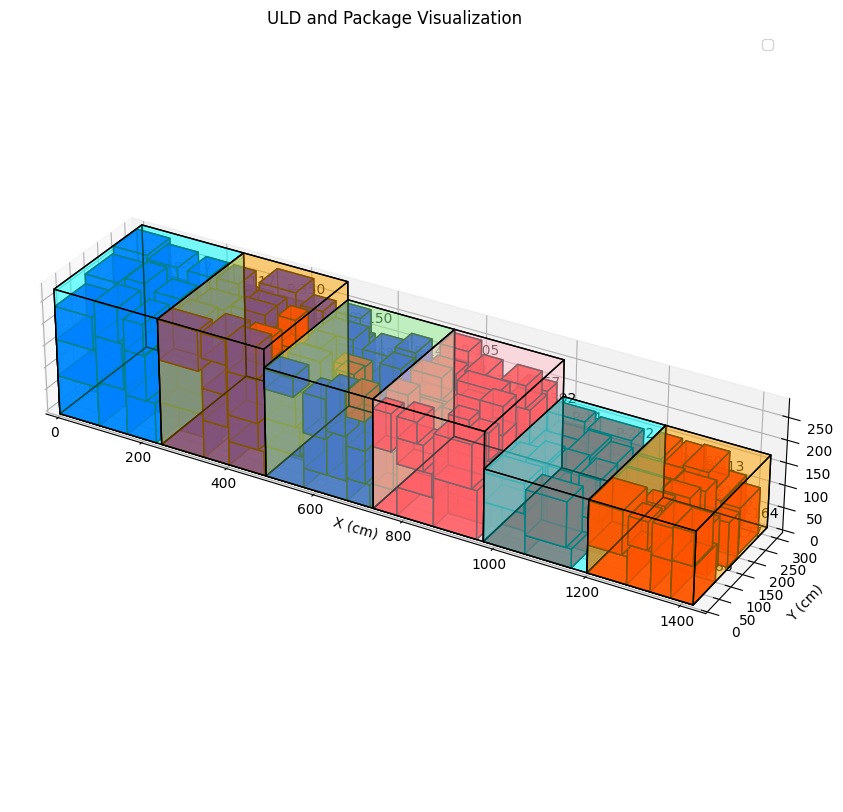

In [21]:
ans_df = ans_from_gene(uld_list, all_boxes, best_full_gene, cost_type="normal")
visualize(uld_df, pkgs_df, ans_df)

In [ ]:
np.save('best_gene_final_all.npy', best_full_gene)

In [22]:
# Replace NaN values in x, y, z with -1
best_full_gene = np.load('best_gene_final_all.npy')
ans = ans_from_gene(uld_list, all_boxes, best_full_gene, cost_type="normal").fillna(-1)

In [ ]:
#ans[ans["ULD Identifier"] != "None"].reset_index(drop=True)

In [23]:
report = validity_report(uld_df, pkgs_df, ans, k=5000)

In [ ]:
report

{'Weight_limit': [],
 'Overlapping': [],
 'Outside': [('P-100', 'None'),
  ('P-101', 'None'),
  ('P-104', 'None'),
  ('P-108', 'None'),
  ('P-11', 'None'),
  ('P-110', 'None'),
  ('P-111', 'None'),
  ('P-113', 'None'),
  ('P-114', 'None'),
  ('P-115', 'None'),
  ('P-116', 'None'),
  ('P-118', 'None'),
  ('P-119', 'None'),
  ('P-120', 'None'),
  ('P-121', 'None'),
  ('P-122', 'None'),
  ('P-127', 'None'),
  ('P-128', 'None'),
  ('P-13', 'None'),
  ('P-131', 'None'),
  ('P-132', 'None'),
  ('P-137', 'None'),
  ('P-138', 'None'),
  ('P-140', 'None'),
  ('P-141', 'None'),
  ('P-143', 'None'),
  ('P-144', 'None'),
  ('P-146', 'None'),
  ('P-149', 'None'),
  ('P-151', 'None'),
  ('P-152', 'None'),
  ('P-153', 'None'),
  ('P-154', 'None'),
  ('P-155', 'None'),
  ('P-156', 'None'),
  ('P-158', 'None'),
  ('P-159', 'None'),
  ('P-160', 'None'),
  ('P-161', 'None'),
  ('P-173', 'None'),
  ('P-176', 'None'),
  ('P-178', 'None'),
  ('P-179', 'None'),
  ('P-18', 'None'),
  ('P-182', 'None'),
  ('P-

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


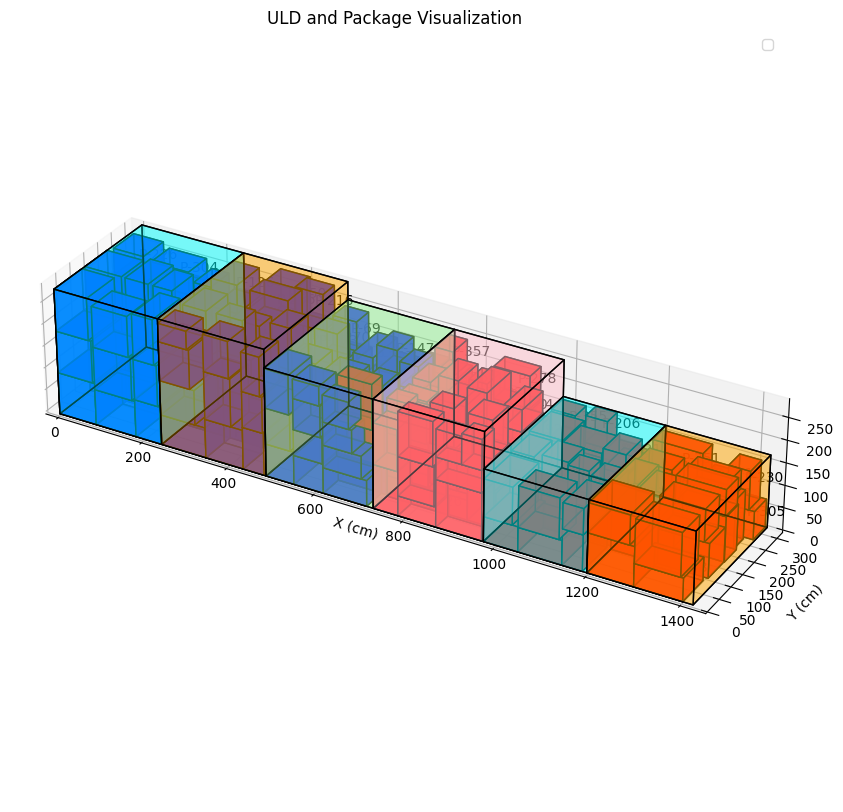

In [ ]:
visualize(uld_df, pkgs_df, ans)

In [24]:
import numpy as np
import pandas as pd

def save_solution_to_txt(ans, total_cost, num_priority_ULDs, output_file):
    """
    Converts a solution DataFrame to the specified .txt format.

    Args:
        ans (pd.DataFrame): The solution DataFrame with columns:
            - Package-ID
            - ULD Identifier
            - x0, y0, z0, x1, y1, z1
        total_cost (int): The total cost of the solution.
        num_priority_ULDs (int): The number of ULDs with priority packages.
        output_file (str): Path to the output .txt file.
    """
    # Count total number of packages packed in ULDs
    total_packed_packages = ans[ans["ULD Identifier"] != "None"].shape[0]

    # Write the first line with total cost, total packages, and number of priority ULDs
    with open(output_file, 'w') as f:
        f.write(f"{total_cost},{total_packed_packages},{num_priority_ULDs}\n")

        # Iterate over the DataFrame and write package details
        for _, row in ans.iterrows():
            package_id = row["Package Identifier"]
            uld_id = row["ULD Identifier"]
            x0, y0, z0 = row["X0"], row["Y0"], row["Z0"]
            x1, y1, z1 = row["X1"], row["Y1"], row["Z1"]

            if uld_id == "None":
                uld_id = "NONE"
                x0, y0, z0, x1, y1, z1 = -1, -1, -1, -1, -1, -1

            f.write(f"{package_id},{uld_id},{x0},{y0},{z0},{x1},{y1},{z1}\n")


# Example usage:
# Load the .npy file
best_full_gene = np.load('best_gene_final_all.npy')

# Compute ans using the provided function ans_from_gene
ans = ans_from_gene(uld_list, all_boxes, best_full_gene, cost_type="normal").fillna(-1)

# Reset the index and filter out packages with "None" ULD Identifier
#ans = ans[ans["ULD Identifier"] != "None"].reset_index(drop=True)

# Assume total_cost and num_priority_ULDs are computed from the solution
total_cost = report['cost']  # Example value
num_priority_ULDs = 3  # Example value

# Save to a .txt file
output_file = 'solution.txt'
save_solution_to_txt(ans, total_cost, num_priority_ULDs, output_file)


# Function to calculate package volume
def calculate_volume(x0, y0, z0, x1, y1, z1):
    return max(0, x1 - x0) * max(0, y1 - y0) * max(0, z1 - z0)

# Read the file
file_path = "solution.txt"  # Replace with your actual file path
uld_packages = {}

with open(file_path, "r") as file:
    lines = file.readlines()[1:]  # Skip the header

# Parse the file
for line in lines:
    parts = line.strip().split(",")
    package_id, uld, *coords = parts
    coords = list(map(float, coords))
    if uld != "NONE":
        volume = calculate_volume(*coords)
        if uld not in uld_packages:
            uld_packages[uld] = []
        uld_packages[uld].append(volume)

# Calculate volumetric efficiency
results = {}
efficiencies = []  # List to store individual efficiencies
for uld, package_volumes in uld_packages.items():
    total_package_volume = sum(package_volumes)
    uld_dimensions = uld_df[uld_df["ULD Identifier"] == uld]
    if not uld_dimensions.empty:
        uld_volume = (
            uld_dimensions["Length (cm)"].iloc[0]
            * uld_dimensions["Width (cm)"].iloc[0]
            * uld_dimensions["Height (cm)"].iloc[0]
        )
        efficiency = (total_package_volume / uld_volume) * 100
        results[uld] = efficiency
        efficiencies.append(efficiency)

# Calculate mean volumetric efficiency
if efficiencies:
    mean_efficiency = sum(efficiencies) / len(efficiencies)
else:
    mean_efficiency = 0

# Print results
sorted_results = dict(sorted(results.items()))
for uld, efficiency in results.items():
    print(f"ULD {uld} Volumetric Efficiency: {efficiency:.2f}%")
print(f"Mean Volumetric Efficiency: {mean_efficiency:.2f}%")


visualize(uld_df, pkgs_df, ans,sorted_results)

print(f"Solution saved to {output_file}")

ULD U3 Volumetric Efficiency: 68.94%
ULD U5 Volumetric Efficiency: 73.92%
ULD U6 Volumetric Efficiency: 72.31%
ULD U1 Volumetric Efficiency: 78.86%
ULD U4 Volumetric Efficiency: 64.21%
ULD U2 Volumetric Efficiency: 71.19%
Mean Volumetric Efficiency: 71.57%


TypeError: visualize() takes 3 positional arguments but 4 were given

In [12]:
# Function to calculate package volume
def calculate_volume(x0, y0, z0, x1, y1, z1):
    return max(0, x1 - x0) * max(0, y1 - y0) * max(0, z1 - z0)

# Read the file
file_path = "solution.txt"  # Replace with your actual file path
uld_packages = {}

with open(file_path, "r") as file:
    lines = file.readlines()[1:]  # Skip the header

# Parse the file
for line in lines:
    parts = line.strip().split(",")
    package_id, uld, *coords = parts
    coords = list(map(float, coords))
    if uld != "NONE":
        volume = calculate_volume(*coords)
        if uld not in uld_packages:
            uld_packages[uld] = []
        uld_packages[uld].append(volume)

# Calculate volumetric efficiency
results = {}
efficiencies = []  # List to store individual efficiencies
for uld, package_volumes in uld_packages.items():
    total_package_volume = sum(package_volumes)
    uld_dimensions = uld_df[uld_df["ULD Identifier"] == uld]
    if not uld_dimensions.empty:
        uld_volume = (
            uld_dimensions["Length (cm)"].iloc[0]
            * uld_dimensions["Width (cm)"].iloc[0]
            * uld_dimensions["Height (cm)"].iloc[0]
        )
        efficiency = (total_package_volume / uld_volume) * 100
        results[uld] = efficiency
        efficiencies.append(efficiency)

# Calculate mean volumetric efficiency
if efficiencies:
    mean_efficiency = sum(efficiencies) / len(efficiencies)
else:
    mean_efficiency = 0

# Print results
sorted_results = dict(sorted(results.items()))
for uld, efficiency in results.items():
    print(f"ULD {uld} Volumetric Efficiency: {efficiency:.2f}%")
print(f"Mean Volumetric Efficiency: {mean_efficiency:.2f}%")


ULD U3 Volumetric Efficiency: 68.94%
ULD U5 Volumetric Efficiency: 73.92%
ULD U6 Volumetric Efficiency: 72.31%
ULD U1 Volumetric Efficiency: 78.86%
ULD U4 Volumetric Efficiency: 64.21%
ULD U2 Volumetric Efficiency: 71.19%
Mean Volumetric Efficiency: 71.57%
